In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
split = 2

In [60]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [61]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [62]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [63]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [64]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [65]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [66]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [67]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [68]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [69]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [70]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [71]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


In [72]:
sc.tl.rank_genes_groups(adata_full, "condition", method="t-test", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

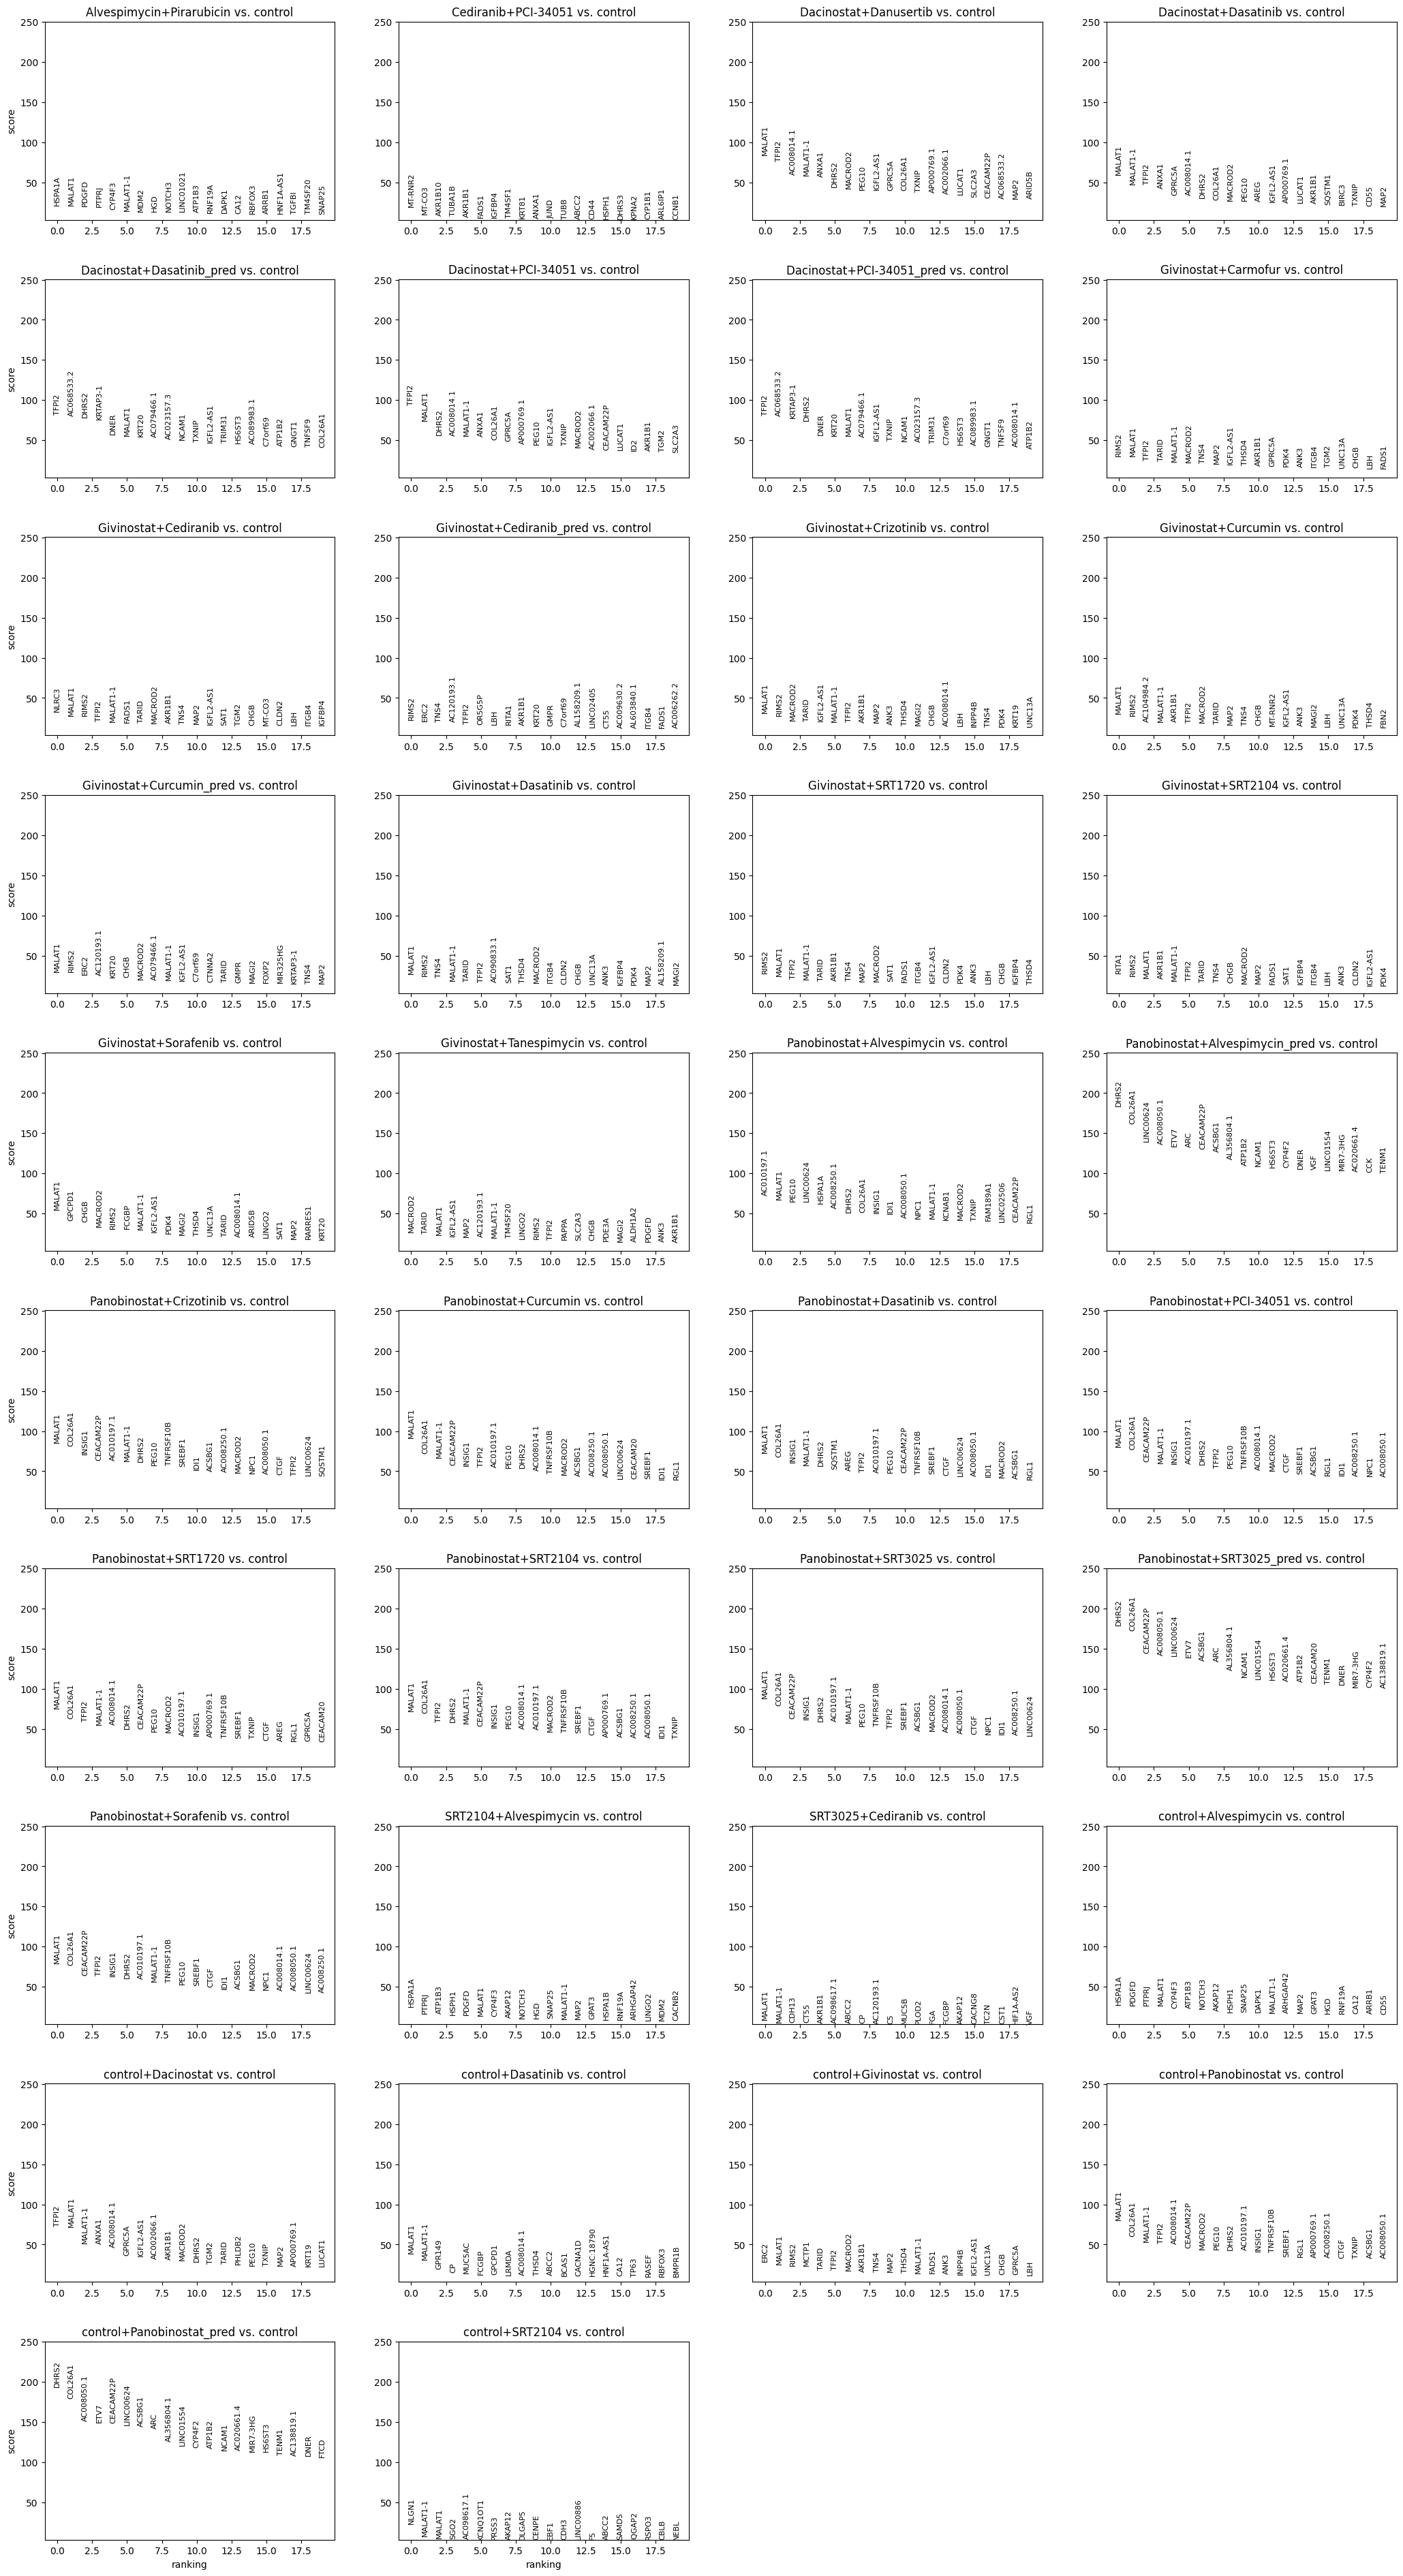

In [73]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [74]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [75]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_225973/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [76]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [77]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+Dasatinib_pred', 'Dacinostat+PCI-34051', 'Dacinostat+PCI-34051_pred', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Cediranib_pred', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Curcumin_pred', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Alvespimycin_pred', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+SRT3025_pred', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+Panobinostat_pred', 'control+SRT2104'])

In [78]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION,-0.899521,-1.933697,0.000000
REACTOME_CHROMOSOME_MAINTENANCE,-0.898213,-1.692091,0.000000
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,-0.912905,-2.016183,0.000000
REACTOME_RESOLUTION_OF_D_LOOP_STRUCTURES_THROUGH_SYNTHESIS_DEPENDENT_STRAND_ANNEALING_SDSA,-0.946271,-1.656953,0.000000
REACTOME_CELL_CYCLE_CHECKPOINTS,-0.877327,-2.172321,0.000000
...,...,...,...
REACTOME_AMINE_LIGAND_BINDING_RECEPTORS,-0.313093,-0.576856,0.919499
REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,-0.287611,-0.505407,0.975089
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,-0.246943,-0.433137,0.987972


In [79]:
gene_sets = reactome[reactome.genesymbol=="CCNB1"]["geneset"].values

In [80]:
res = {}
res_score = {}
res_norm = {}
for gene_set in gene_sets:
    for cond, df in dict_gsea_results.items():
        try:
            res[f"{gene_set}_{cond}"] = df.loc[gene_set]["pval"]
            res_score[f"{gene_set}_{cond}"] = df.loc[gene_set]["score"]
        except:
            continue
    

In [81]:
res

{'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Alvespimycin+Pirarubicin': 0.19159664,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Cediranib+PCI-34051': 0.004608295,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+Danusertib': 0.85333335,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+Dasatinib': 0.8754864,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+Dasatinib_pred': 0.7751825,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+PCI-34051': 0.8330309,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+PCI-34051_pred': 0.81395346,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Carmofur': 0.29449838,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Cediranib': 0.5826972,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Cediranib_pred': 0.85971683,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Crizotinib': 0.44321328,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Curcumin': 0.27696794,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Curcumin_pred': 0.18951613,
 'REACTOME_NUCLEAR_ENVELOPE_BREA

In [57]:
res_score

{'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Alvespimycin+Pirarubicin': -0.69133,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Cediranib+PCI-34051': 0.8002951,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+Danusertib': 0.40880814,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+Dasatinib': -0.38213295,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Dacinostat+PCI-34051': 0.40814447,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Carmofur': -0.53272593,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Cediranib': -0.42815682,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Crizotinib': -0.48039773,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Curcumin': -0.55043966,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Dasatinib': -0.6736935,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+Dasatinib_pred': -0.5247448,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+SRT1720': -0.3200927,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Givinostat+SRT1720_pred': -0.5087263,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN_Gi

In [ ]:
'REACTOME_MITOTIC_PROPHASE'
'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_RUNX2'

In [55]:
df.loc[gene_set]

score    0.337697
norm     0.784479
pval     0.736170
Name: REACTOME_TRANSCRIPTIONAL_REGULATION_BY_RUNX2, dtype: float32

In [51]:
[el for el in reactome.genesymbol.cat.categories if

SyntaxError: incomplete input (3602845654.py, line 1)

In [44]:
reactome.genesymbol.value_counts()["MKI67"]

0

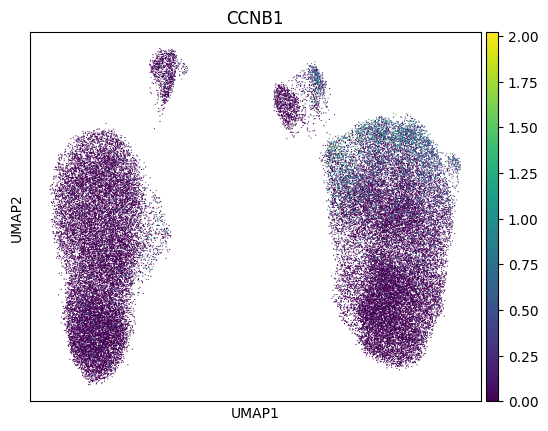

In [58]:
sc.pl.umap(adata_train, color="CCNB1")